In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Process the Data

In [9]:
df_veteran = pd.read_csv('veteran-counts.csv')
df_zip = pd.read_csv('zip-fips-xwalk.csv')

In [82]:
#process address 

df_address = pd.read_csv('vha-adresses.txt',sep = '\n',header = None)
df_address.columns = ['address']

def get_zip(addr):
    code = addr.split()[-1]
    if '-' in code:
        code = code.split('-')[0]
    return int(code)

def get_state(addr):
    return addr.split()[-2]

df_address['ZIP5'] = df_address['address'].apply(get_zip)
df_address['State'] = df_address['address'].apply(lambda x: get_state(x))

df_address = df_address.merge(df_zip, on = 'ZIP5',how = 'left')
FIPS_set = set(int(i) for i in df_address['CountyFIPS'] if i > 0)
state_set = set(s for s in df_address['State'])

In [424]:
len(state_set)

50

In [375]:
df_matchable = df_address[~df_address['CountyFIPS'].isna()]
df_matchable['CountyFIPS'] = df_matchable['CountyFIPS'].apply(lambda x: int(x))

<ipython-input-375-f70f0781af2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchable['CountyFIPS'] = df_matchable['CountyFIPS'].apply(lambda x: int(x))


In [380]:
df_matchable['County_State']=df_matchable['CountyFIPS'].apply(lambda x:fips_county_map[x])

<ipython-input-380-02710d668317>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchable['County_State']=df_matchable['CountyFIPS'].apply(lambda x:fips_county_map[x])


In [422]:
df_addcounty = pd.DataFrame(df_address.groupby('CountyFIPS')['address'].count().sort_values(ascending = False))
df_addcounty.describe(include = 'all')

,address
count,888.000000
mean,1.667793
std,1.468573
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,18.000000


In [423]:
VHA_county = df_matchable.groupby('County_State')['address'].count().sort_values(ascending = False)
VHA_county

County_State
Los Angeles,CA    18
Cook,IL           14
Bexar,TX          13
San Diego,CA      11
Maricopa,AZ       11
                  ..
Logan,WV           1
Lorain,OH          1
Clay,MO            1
Lowndes,GA         1
Newport,RI         1
Name: address, Length: 888, dtype: int64

In [97]:
# Process Veteran Dataframe
df_veteran['if_VHA'] = df_veteran['FIPS'].apply(lambda x:x in FIPS_set)
df_veteran['if_65+'] = df_veteran['Age.Group'].apply(lambda x: x in ['65-84','85+'])
df_veteran['State'] = df_veteran['County..St'].apply(lambda x: x.split(',')[-1])

fips_county = set((s[0],s[1]) for c,s in df_veteran[['FIPS','County..St']].iterrows())
fips_county_map = {k:v for k,v in fips_county}

In [91]:
total_veterans = df_veteran['Veterans'].sum()

20333894.290001765

In [407]:
def plot_pie(data,labels,title = 'Pie Chart'):
    n = data.shape[0]
    colors = sns.color_palette('pastel')[:n]
    plt.figure(figsize=(8,5))
    plt.pie(data,labels = labels, colors = colors, autopct= lambda x: f'{x:.1f}%',textprops={'fontsize':12,'weight':'bold'})
    plt.title(title,size = 20,weight = 'bold')
    plt.savefig(f'{title}.png')
    plt.show()
    

# Questions
• What proportion of eligible veterans live in a county with a VHA Facility? \
• Which county or counties contain the highest number of veterans? \
• Are there oddities or interesting points you can identify in the data?

## Q1 
• What proportion of eligible veterans live in a county with a VHA Facility? 

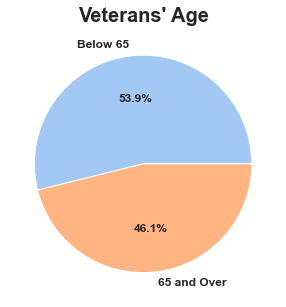

In [408]:
if_65 = pd.DataFrame(df_veteran.groupby('if_65+')['Veterans'].sum())
labels = ['Below 65','65 and Over']
plot_pie(if_65['Veterans'],labels,"Veterans' Age")


In [159]:
#without VHA, with VHA
data65 = list(df_veteran.groupby(['if_65+','if_VHA'])['Veterans'].sum())
over65 = data65[2:]
below65 = data65[:2]
overall = list(df_veteran.groupby('if_VHA')['Veterans'].sum())

In [391]:
df_vha = pd.DataFrame([below65,over65,overall],columns=['without_VHA','with_VHA'],index = ['Below 65','65 and Over','Overall'])
df_vha

,without_VHA,with_VHA
Below 65,2.668635e+06,8.288627e+06
65 and Over,2.490744e+06,6.885888e+06
Overall,5.159379e+06,1.517452e+07


In [194]:
df_vha['with_VHA'][0]

8288626.989157979

<ipython-input-392-4850998c651e>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('vha_proportion.png',bbox = 'tight')


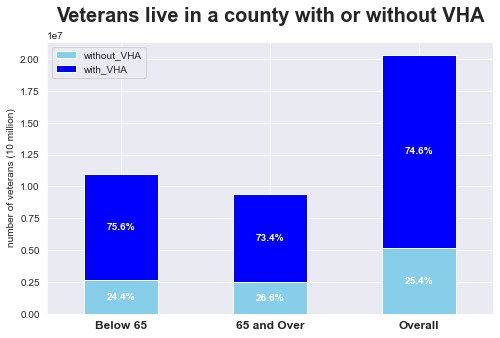

In [392]:
df_vha.plot(kind = 'bar', stacked = True,color = ['skyblue','blue'],figsize = (8,5))
sns.set_style("darkgrid")

for ix, row in df_vha.reset_index(drop = True).iterrows():
    cumulative = 0
    total = sum(row)
    for element in row:
        plt.text(ix,cumulative+element/2,
                 f'{(element/total)*100:.1f}%',
                 va = 'center',
                 ha = 'center',
                 color = 'white',
                 weight = 'bold')
        cumulative+=element
plt.xticks(rotation=0,size = 12,weight = 'bold')
plt.ylabel('number of veterans (10 million)')
plt.title('Veterans live in a county with or without VHA', size = 20,weight = 'bold',pad = 20)
plt.savefig('vha_proportion.png',bbox = 'tight')

## Q2
• Which county or counties contain the highest number of veterans?

In [212]:
df_veteran_by_county = df_veteran.groupby('County..St').agg({'FIPS':'mean','Veterans':'sum'}).sort_values(by = ['Veterans'],ascending= False)
df_veteran_by_county.head(10)

,FIPS,Veterans
County..St,,
"Los Angeles,CA",6037.0,294455.761573
"Maricopa,AZ",4013.0,278911.789119
"San Diego,CA",6073.0,260840.873275
"Harris,TX",48201.0,188679.576620
"Cook,IL",17031.0,185226.955658
"Bexar,TX",48029.0,160836.756983
"Clark,NV",32003.0,160131.597506
"Riverside,CA",6065.0,122690.972771
"Orange,CA",6059.0,122678.981700


/Users/Young/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


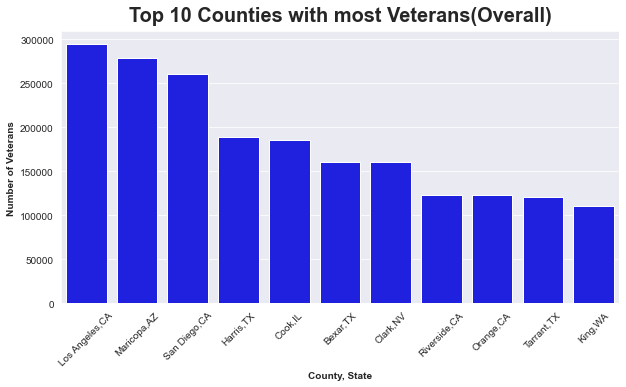

In [404]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.barplot(df_veteran_by_county.index[:11],df_veteran_by_county['Veterans'][:11],color = 'blue')
plt.xticks(rotation = 45)
plt.xlabel('County, State',weight = 'bold')
plt.ylabel('Number of Veterans',weight = 'bold')
plt.title('Top 10 Counties with most Veterans(Overall)',size = 20,weight = 'bold',pad = 10)
plt.savefig('top10_counties_overall.png',bbox_inches = 'tight')
plt.show()

In [398]:
df_veteran65_by_county = df_veteran[df_veteran['if_65+']==True].groupby('County..St').agg({'FIPS':'mean','Veterans':'sum'}).sort_values(by = ['Veterans'],ascending= False)

/Users/Young/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


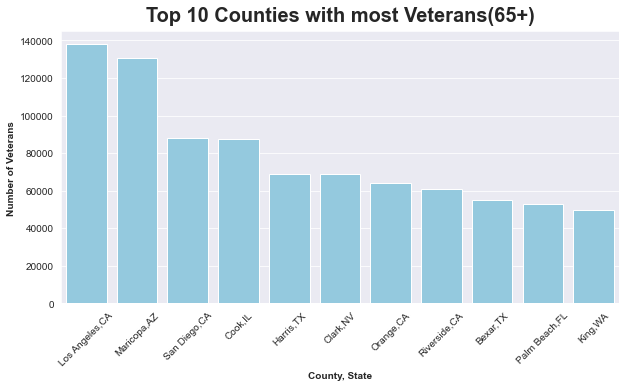

In [403]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")

sns.barplot(df_veteran65_by_county.index[:11],df_veteran65_by_county['Veterans'][:11],color = 'skyblue')
plt.xticks(rotation = 45)
plt.xlabel('County, State',weight = 'bold')
plt.ylabel('Number of Veterans',weight = 'bold')
plt.title('Top 10 Counties with most Veterans(65+)',size = 20,weight = 'bold',pad = 10)
plt.savefig('top10_counties_65+.png',bbox_inches = 'tight')
plt.show()

/Users/Young/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


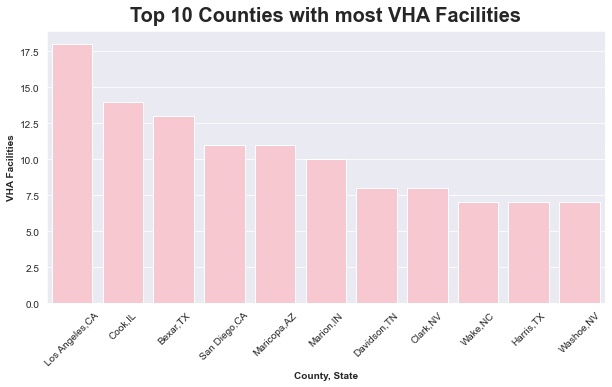

In [413]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.barplot(VHA_county.index[:11],VHA_county[:11],color = 'pink')
plt.xticks(rotation = 45)
plt.xlabel('County, State',weight = 'bold')
plt.ylabel('VHA Facilities',weight = 'bold')
plt.title('Top 10 Counties with most VHA Facilities',size = 20,weight = 'bold',pad = 10)
plt.savefig('top10countiesVHA.png',bbox_inches = 'tight')
plt.show()

## Q3
- What about the veterans live in a county without VHA?

In [339]:
df_address.groupby('CountyFIPS')['address'].count().sort_values(ascending = False)

CountyFIPS
6037.0     18
17031.0    14
48029.0    13
4013.0     11
6073.0     11
           ..
27109.0     1
27111.0     1
27139.0     1
27145.0     1
56043.0     1
Name: address, Length: 888, dtype: int64

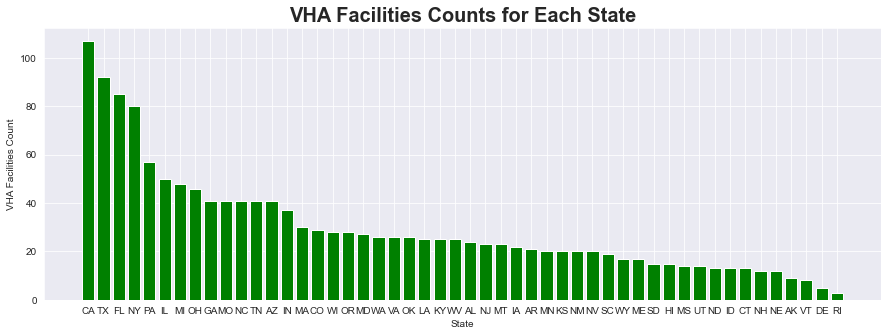

In [418]:
df_VHA_state = df_address.groupby('State')['address'].count().sort_values(ascending = False)
plt.figure(figsize=(15,5))
plt.bar(df_VHA_state.index,df_VHA_state,color = 'green')
plt.title('VHA Facilities Counts for Each State',weight = 'bold',size = 20)
plt.xlabel('State')
plt.ylabel('VHA Facilities Count')
plt.savefig('VHA_count.png',bbox_inches = 'tight')
plt.show()

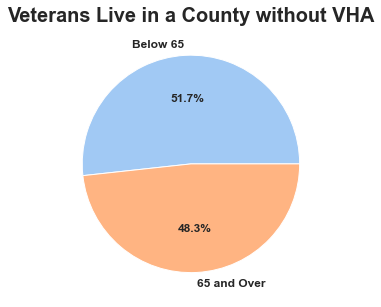

In [414]:
noVHA = df_veteran[df_veteran['if_VHA']==False].groupby('if_65+')['Veterans'].sum()
plot_pie(noVHA,['Below 65','65 and Over'],'Veterans Live in a County without VHA')

In [305]:
df_noVHA65 = df_veteran[(df_veteran['if_VHA']==False)&df_veteran['if_65+']==True]
df_noVHA65

,FIPS,County..St,Age.Group,Gender,Veterans,if_VHA,if_65+,State
2,1001,"Autauga,AL",65-84,F,79.197187,False,True,AL
3,1001,"Autauga,AL",85+,F,3.746539,False,True,AL
6,1001,"Autauga,AL",65-84,M,1740.645015,False,True,AL
7,1001,"Autauga,AL",85+,M,271.104573,False,True,AL
10,1003,"Baldwin,AL",65-84,F,114.974149,False,True,AL
...,...,...,...,...,...,...,...,...
25175,90078,Virgin Islands,85+,M,178.032246,False,True,Virgin Islands
25178,99000,Foreign Countries,65-84,F,787.613698,False,True,Foreign Countries
25179,99000,Foreign Countries,85+,F,120.714372,False,True,Foreign Countries
25182,99000,Foreign Countries,65-84,M,28410.135300,False,True,Foreign Countries


In [314]:
noVHA65_county = df_noVHA65.groupby('County..St')['Veterans'].sum().sort_values(ascending = False)
total_noVHA65 = sum(noVHA65_county)
noVHA65_county[:10],noVHA65_county[:10]/total_noVHA65

(County..St
 Puerto Rico,PR             46236.309638
 Foreign Countries          35070.521871
 Seminole,FL                15185.860110
 Citrus,FL                  14652.257154
 Waukesha,WI                13535.967924
 Prince William,VA          11943.262290
 Chesterfield,VA            11403.604912
 District Of Columbia,DC    11209.863103
 Lexington,SC               10578.692165
 Baldwin,AL                 10264.843355
 Name: Veterans, dtype: float64,
 County..St
 Puerto Rico,PR             0.018563
 Foreign Countries          0.014080
 Seminole,FL                0.006097
 Citrus,FL                  0.005883
 Waukesha,WI                0.005435
 Prince William,VA          0.004795
 Chesterfield,VA            0.004578
 District Of Columbia,DC    0.004501
 Lexington,SC               0.004247
 Baldwin,AL                 0.004121
 Name: Veterans, dtype: float64)

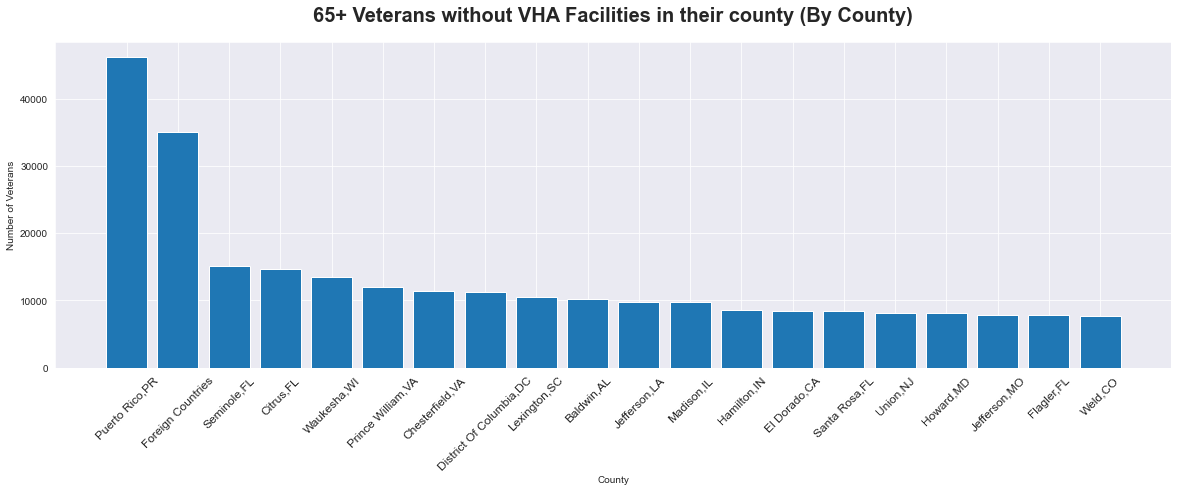

In [415]:
plt.figure(figsize = (20,6))
plt.bar(noVHA65_county[:20].index,noVHA65_county[:20])
plt.xticks(rotation = 45,size = 12)
plt.xlabel('County')
plt.ylabel('Number of Veterans')
plt.title('65+ Veterans without VHA Facilities in their county (By County)',size = 20,pad = 20,weight = 'bold')
plt.savefig('65withoutVHA_county.png',bbox_inches = 'tight')
plt.show()

In [326]:
noVHA65_state = df_noVHA65.groupby('State')['Veterans'].sum().sort_values(ascending = False)

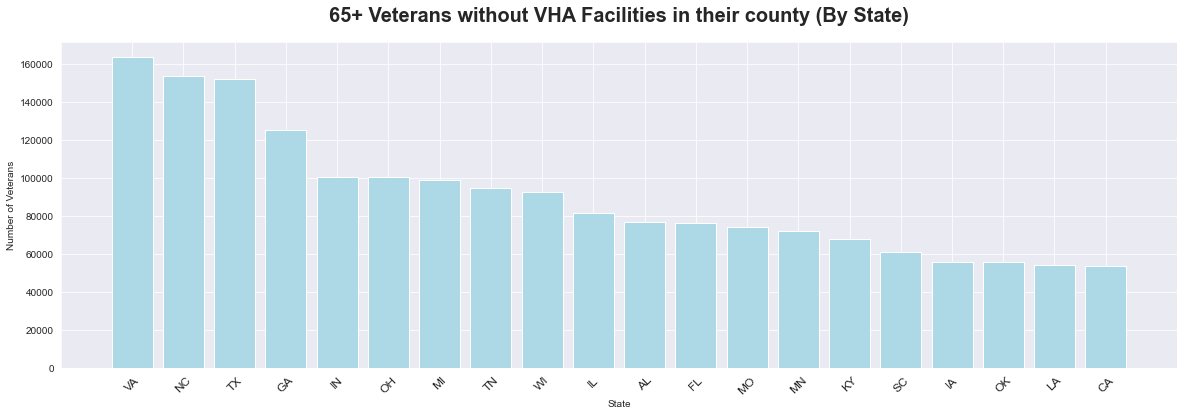

In [419]:
plt.figure(figsize = (20,6))
plt.bar(noVHA65_state[:20].index,noVHA65_state[:20],color = 'lightblue')
plt.xticks(rotation = 45,size = 12)
plt.xlabel('State')
plt.ylabel('Number of Veterans')
plt.title('65+ Veterans without VHA Facilities in their county (By State)',size = 20,pad = 20,weight = 'bold')
plt.savefig('65noVHA_state.png',bbox_inches = 'tight')
plt.show()